### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра информационных технологий

## ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ № 6


### Дисциплина: Методы машинного обучения

##### Студент:  Кузнецов Юрий Владимирович
##### Группа:   НФИбд 01-20

## Москва 2023
***

### Вариант №21

1. Набор данных deep_weeds

2. Классы с метками 1,2,3

### Задание:

В соответствии с индивидуальным заданием, указанным в записной книжке команды, выполните следующие работы:  

1. Загрузите заданный в индивидуальном задании набор данных с изображениями из Tensorflow Datasets с разбиением на обучающую и тестовую выборки.
2. Визуализируйте несколько изображений, отобранных случайным образом из обучающей выборки.
3. Оставьте в наборе изображения двух классов, указанных в индивидуальном задании первыми. Обучите нейронные сети MLP и CNN задаче бинарной классификации изображений (архитектура сетей по вашему усмотрению).  
4. Постройте кривые обучения нейронных сетей для показателей ошибки и аккуратности в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду.
5. Сравните качество бинарной классификации нейронными сетями при помощи матрицы ошибок для тестовой выборки.  
6. Визуализируйте ROC-кривые для построенных классификаторов на одном рисунке (с легендой) и вычислите площади под ROC-кривыми.
7. Оставьте в наборе изображения трех классов, указанных в индивидуальном задании. Обучите нейронные сети MLP и CNN задаче многоклассовой классификации изображений (архитектура сетей по вашему усмотрению).  
8. Сравните качество многоклассовой классификации нейронными сетями при помощи матрицы ошибок (для трех классов) для тестовой выборки.  
9. Постройте кривые обучения нейронных сетей для показателей ошибки и аккуратности в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду.

# Решение

In [ ]:
# !pip install -q tfds-nightly
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from PIL import Image, ImageOps

**1.** Загрузим заданный в индивидуальном задании набор данных с изображениями из Tensorflow Datasets с разбиением на обучающую и тестовую выборки:

In [ ]:

ds_train = tfds.load("deep_weeds", split='train[:50%]')
ds_test = tfds.load("deep_weeds", split='train[50%:57%]')
df_train = tfds.as_dataframe(ds_train)
df_test  = tfds.as_dataframe(ds_test)
df_train.shape, df_test.shape

((8754, 2), (1226, 2))

In [ ]:
def convert_to_labels_and_images(df_train, df_test):
  train_labels = df_train['label'].to_numpy(dtype=np.float32)
  test_labels = df_test['label'].to_numpy(dtype=np.float32)

  train_images = np.zeros(shape=(df_train.shape[0],100, 100, 3), dtype=np.float32)
  test_images  = np.zeros(shape=(df_test.shape[0],100, 100, 3), dtype=np.float32)

  for idx in range(train_labels.shape[0]):
    train_images[idx,:,:,:] = np.array(Image.fromarray(df_train.iloc[idx]['image']).resize((100,100)))

  for idx in range(test_labels.shape[0]):
    test_images[idx,:,:,:] = np.array(Image.fromarray(df_test.iloc[idx]['image']).resize((100,100)))

  train_images /= 255
  test_images  /= 255

  return train_images, train_labels, test_images, test_labels

In [ ]:
train_images, train_labels, test_images, test_labels = convert_to_labels_and_images(df_train, df_test)

**2.** Визуализируем несколько изображений, отобранных случайным образом из обучающей выборки:

In [ ]:
import random

def plot_random_sample(images):
    n = 10
    imgs = random.sample(list(images), n)

    num_row = 2
    num_col = 5

    fig, axes = plt.subplots(num_row, num_col, figsize=(3.5 * num_col, 3 * num_row))
    # For every image
    for i in range(num_row * num_col):
        # Read the image
        img = imgs[i]
        # Display the image
        ax = axes[i // num_col, i % num_col]
        ax.imshow(img)

    plt.tight_layout()
    plt.show()

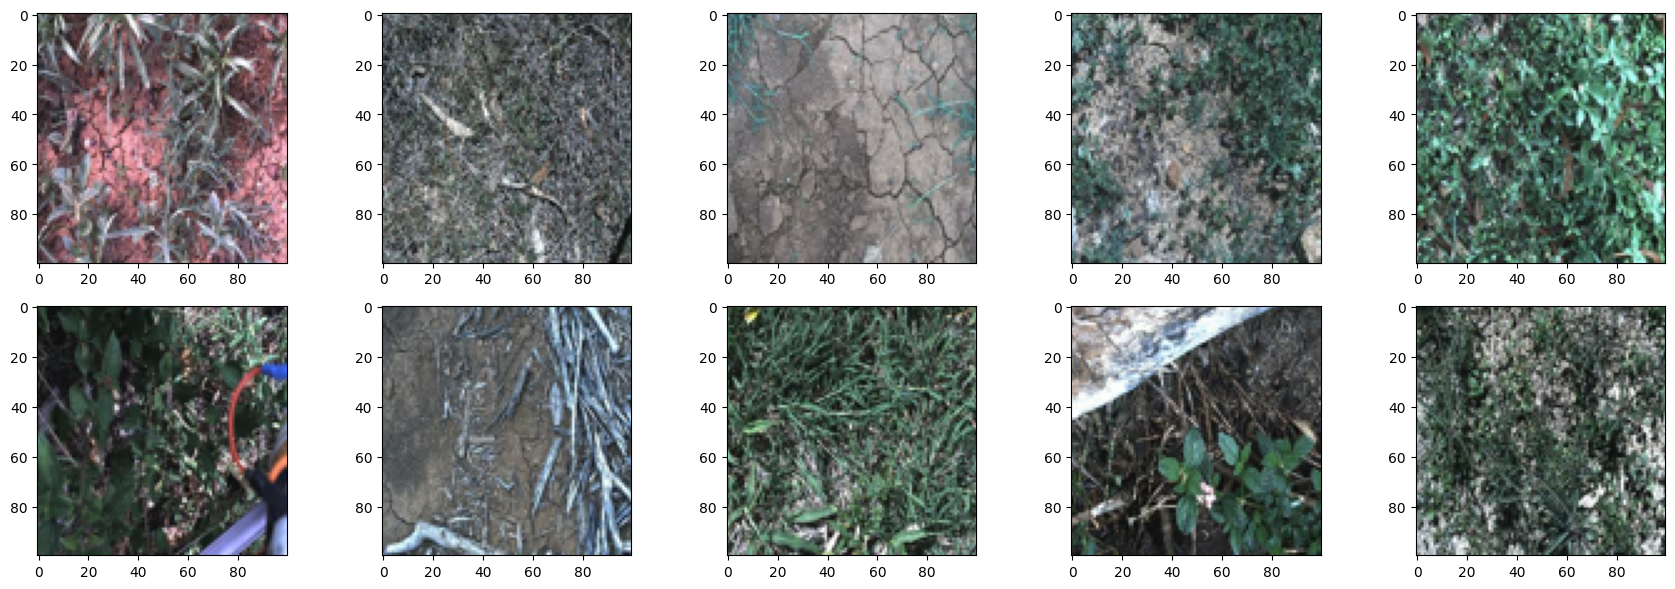

In [ ]:
plot_random_sample(train_images)

**3.** Оставим в наборе только изображения классов 1 и 2 :

In [ ]:
df_train = tfds.as_dataframe(ds_train)
df_test  = tfds.as_dataframe(ds_test)

df_train = df_train.loc[((df_train['label'] == 1) | (df_train['label' ] == 2))]
df_test = df_test.loc[((df_test['label'] == 1) | (df_test['label' ] == 2))]

In [ ]:
df_train.shape, df_test.shape

((1053, 2), (149, 2))

In [ ]:
train_images, train_labels, test_images, test_labels = convert_to_labels_and_images(df_train, df_test)
train_labels -= 1 #  вычитаем 1, чтобы
test_labels -= 1 #  классы обозначались как 0 и 1

Обучим нейронную сеть MLP задаче бинарной классификации изображений:

In [ ]:
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(100, 100, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_1.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

history_1 = model_1.fit(
    train_images,
    train_labels,
    epochs=50,
    batch_size=32,
    validation_data=(test_images, test_labels)
)

Epoch 1/50
33/33 [==============================] - 6s 77ms/step - loss: 1.2157 - accuracy: 0.5204 - val_loss: 0.7934 - val_accuracy: 0.4564
Epoch 2/50
33/33 [==============================] - 2s 59ms/step - loss: 0.6700 - accuracy: 0.6087 - val_loss: 0.8076 - val_accuracy: 0.4765
Epoch 3/50
33/33 [==============================] - 2s 51ms/step - loss: 0.6041 - accuracy: 0.6752 - val_loss: 0.6282 - val_accuracy: 0.6711
Epoch 4/50
33/33 [==============================] - 2s 62ms/step - loss: 0.5429 - accuracy: 0.7227 - val_loss: 0.7415 - val_accuracy: 0.6242
Epoch 5/50
33/33 [==============================] - 2s 50ms/step - loss: 0.5485 - accuracy: 0.7056 - val_loss: 0.7306 - val_accuracy: 0.5101
Epoch 6/50
33/33 [==============================] - 3s 76ms/step - loss: 0.5248 - accuracy: 0.7255 - val_loss: 0.7445 - val_accuracy: 0.5034
Epoch 7/50
33/33 [==============================] - 2s 55ms/step - loss: 0.5966 - accuracy: 0.6790 - val_loss: 0.6265 - val_accuracy: 0.6913
Epoch 8/50
33

Обучим нейронную сеть CNN задаче бинарной классификации изображений:

In [ ]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), input_shape=(100, 100, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_2.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

history_2 = model_2.fit(
    train_images,
    train_labels,
    epochs=15,
    batch_size=32,
    validation_data=(test_images, test_labels)
)

Epoch 1/15
33/33 [==============================] - 12s 316ms/step - loss: 0.6236 - accuracy: 0.6439 - val_loss: 0.5003 - val_accuracy: 0.7517
Epoch 2/15
33/33 [==============================] - 8s 249ms/step - loss: 0.3340 - accuracy: 0.8765 - val_loss: 0.2773 - val_accuracy: 0.8926
Epoch 3/15
33/33 [==============================] - 10s 291ms/step - loss: 0.2061 - accuracy: 0.9231 - val_loss: 0.1756 - val_accuracy: 0.9463
Epoch 4/15
33/33 [==============================] - 10s 314ms/step - loss: 0.1260 - accuracy: 0.9639 - val_loss: 0.2374 - val_accuracy: 0.8792
Epoch 5/15
33/33 [==============================] - 12s 377ms/step - loss: 0.0999 - accuracy: 0.9696 - val_loss: 0.2389 - val_accuracy: 0.8658
Epoch 6/15
33/33 [==============================] - 9s 277ms/step - loss: 0.1180 - accuracy: 0.9554 - val_loss: 0.1554 - val_accuracy: 0.9329
Epoch 7/15
33/33 [==============================] - 10s 304ms/step - loss: 0.0429 - accuracy: 0.9934 - val_loss: 0.1154 - val_accuracy: 0.9463
E

**4.** Построим кривые обучения нейронных сетей бинарной классификации для показателей ошибки и доли верных ответов в зависимости от эпохи обучения:

In [ ]:
from matplotlib import rcParams

rcParams['figure.figsize'] = (12, 6)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

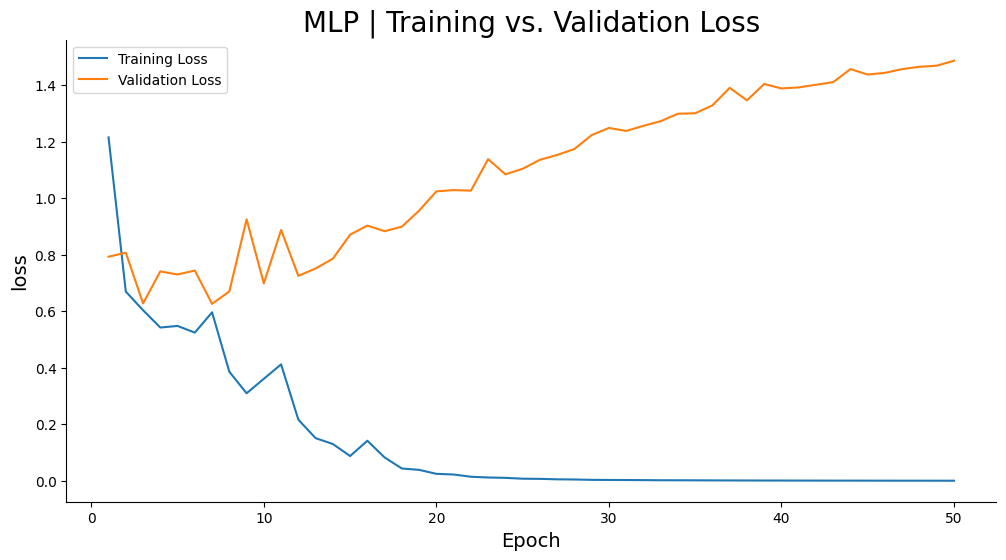

In [ ]:
plt.plot(np.arange(1, 51), history_1.history['loss'], label='Training Loss')
plt.plot(np.arange(1, 51), history_1.history['val_loss'], label='Validation Loss')
plt.title('MLP | Training vs. Validation Loss', size=20)
plt.xlabel('Epoch', size=14)
plt.ylabel('loss', size=14)
plt.legend();

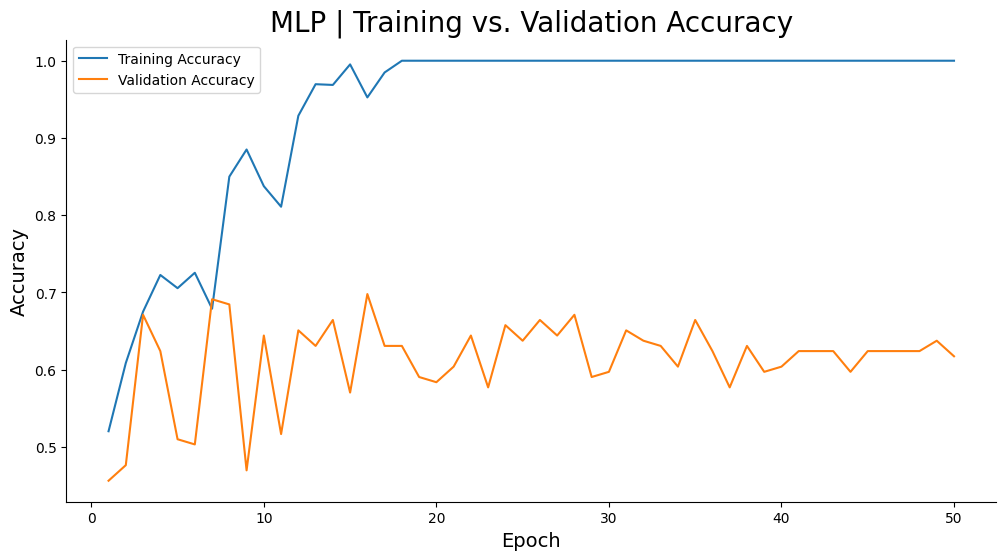

In [ ]:
plt.plot(np.arange(1, 51), history_1.history['accuracy'], label='Training Accuracy')
plt.plot(np.arange(1, 51), history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('MLP | Training vs. Validation Accuracy', size=20)
plt.xlabel('Epoch', size=14)
plt.ylabel('Accuracy', size=14)
plt.legend();

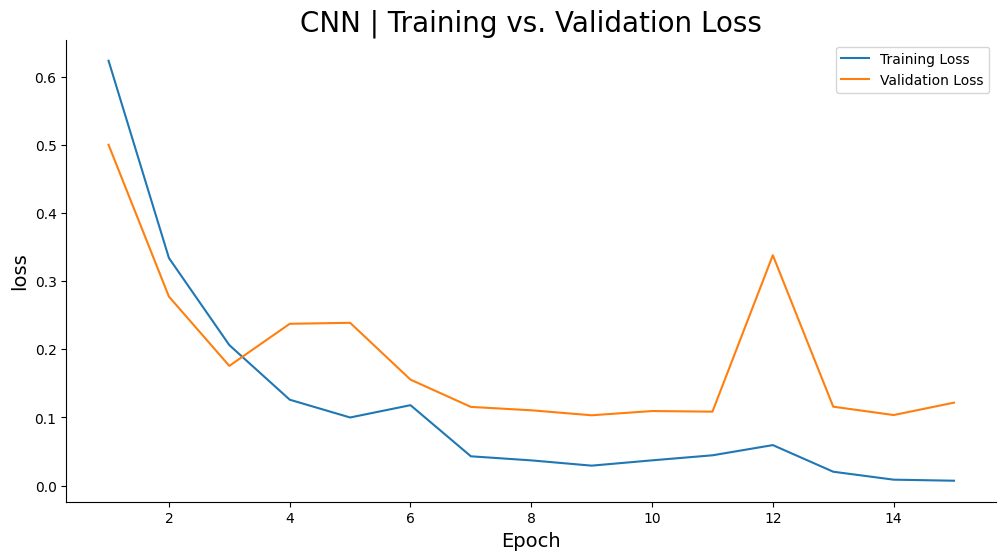

In [ ]:
plt.plot(np.arange(1, 16), history_2.history['loss'], label='Training Loss')
plt.plot(np.arange(1, 16), history_2.history['val_loss'], label='Validation Loss')
plt.title('CNN | Training vs. Validation Loss', size=20)
plt.xlabel('Epoch', size=14)
plt.ylabel('loss', size=14)
plt.legend();

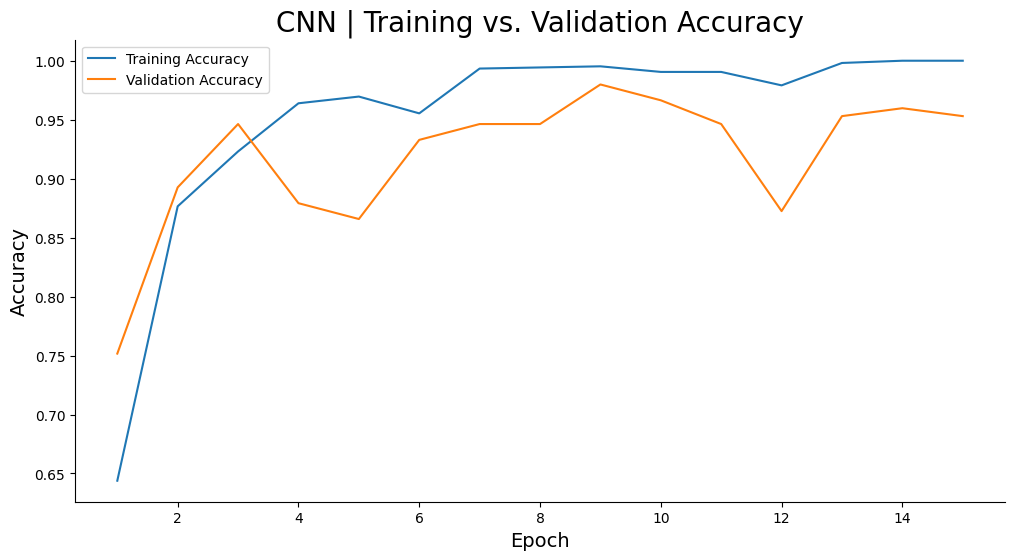

In [ ]:
plt.plot(np.arange(1, 16), history_2.history['accuracy'], label='Training Accuracy')
plt.plot(np.arange(1, 16), history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN | Training vs. Validation Accuracy', size=20)
plt.xlabel('Epoch', size=14)
plt.ylabel('Accuracy', size=14)
plt.legend();

**5.** Сравним качество бинарной классификации нейронными сетями при помощи матрицы ошибок для тестовой выборки:

In [ ]:
def TN(y_true, y_predict):
    assert len(y_true) == len(y_predict)
    return np.sum((y_true == 0) & (y_predict == 0))

In [ ]:
def FP(y_true, y_predict):
    assert len(y_true) == len(y_predict)
    return np.sum((y_true == 0) & (y_predict == 1))

In [ ]:
def FN(y_true, y_predict):
    assert len(y_true) == len(y_predict)
    return np.sum((y_true == 1) & (y_predict == 0))

In [ ]:
def TP(y_true, y_predict):
    assert len(y_true) == len(y_predict)
    return np.sum((y_true == 1) & (y_predict == 1))

In [ ]:
def confusion_matrix(y_true, y_predict):
    return np.array([
        [TP(y_true, y_predict), FN(y_true, y_predict)],
        [FP(y_true, y_predict), TN(y_true, y_predict)]
    ])

Вычислим матрицу ошибок для MLP:

In [ ]:
prediction_1 = model_1.predict(test_images)
pred_labels_1 = np.array([1 if prob > 0.5 else 0 for prob in np.ravel(prediction_1)])
confusion_matrix(test_labels, pred_labels_1)

5/5 [==============================] - 1s 27ms/step


array([[49, 30],
       [27, 43]])

Вычислим матрицу ошибок для CNN:

In [ ]:
prediction_2 = model_2.predict(test_images)
pred_labels_2 = np.array([1 if prob > 0.5 else 0 for prob in np.ravel(prediction_2)])
confusion_matrix(test_labels, pred_labels_2)

5/5 [==============================] - 1s 175ms/step


array([[74,  5],
       [ 2, 68]])

Видим, что качество бинарной классификации CNN несколько выше.

**6.** Визуализируем ROC-кривые для построенных классификаторов:

In [ ]:
def true_false_positive(threshold_vector, y_test):
    true_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 1)
    true_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 0)
    false_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 0)
    false_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 1)

    tpr = true_positive.sum() / (true_positive.sum() + false_negative.sum())
    fpr = false_positive.sum() / (false_positive.sum() + true_negative.sum())

    return tpr, fpr

In [ ]:
def roc_from_scratch(probabilities, y_test, partitions=100):
    roc = np.array([])
    for i in range(partitions + 1):

        threshold_vector = np.greater_equal(probabilities, i / partitions).astype(int)
        tpr, fpr = true_false_positive(threshold_vector, y_test)
        roc = np.append(roc, [fpr, tpr])

    return roc.reshape(-1, 2)

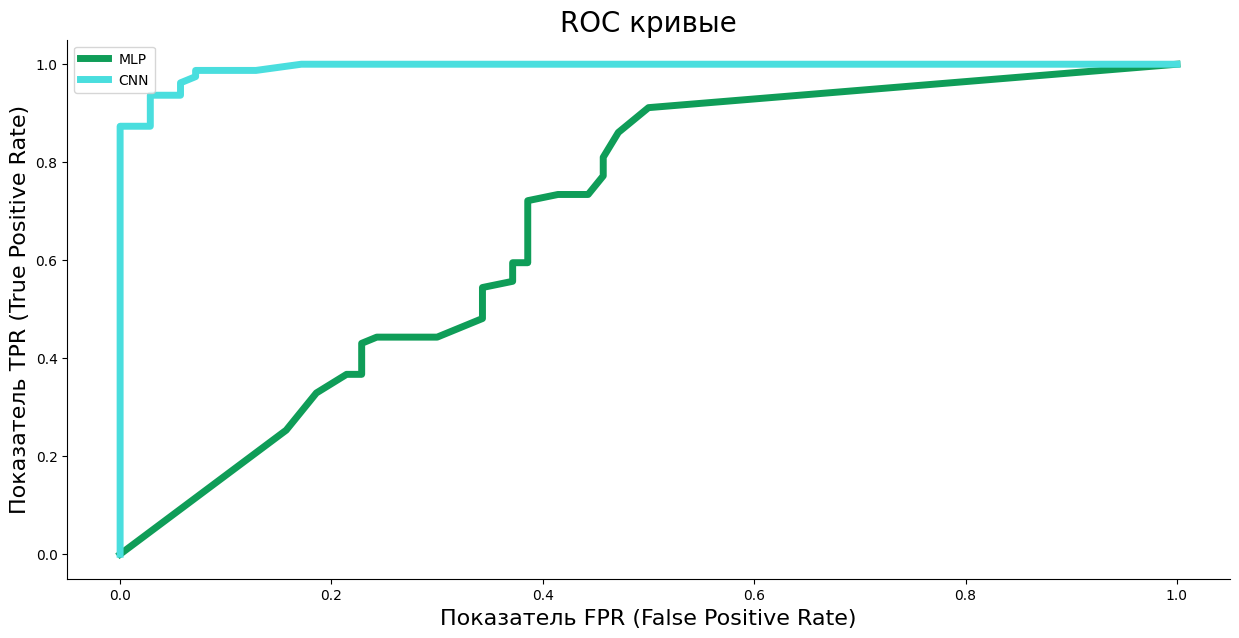

In [ ]:
plt.figure(figsize=(15,7))

ROC_1 = roc_from_scratch(prediction_1.reshape(-1),test_labels,partitions=50)
ROC_2 = roc_from_scratch(prediction_2.reshape(-1),test_labels,partitions=50)
plt.plot(ROC_1[:,0],ROC_1[:,1],color='#0F9D58',lw=5)
plt.plot(ROC_2[:,0],ROC_2[:,1],color='#4ADEDE',lw=5)
plt.title('ROC кривые',fontsize=20)
plt.xlabel('Показатель FPR (False Positive Rate)',fontsize=16)
plt.ylabel('Показатель TPR (True Positive Rate)',fontsize=16)
plt.legend(['MLP', 'CNN'])

Вычислим площади под кривыми:

In [ ]:
S_1 = 0
x_, y_ = ROC_1[:,0], ROC_1[:,1]
for i in range(len(x_) - 1):
  S_1 += abs(x_[i] - x_[i+1]) * (y_[i] + y_[i+1]) / 2
S_1

0.686618444846293

In [ ]:
S_2 = 0
x_, y_ = ROC_2[:,0], ROC_2[:,1]
for i in range(len(x_) - 1):
  S_2 += abs(x_[i] - x_[i+1]) * (y_[i] + y_[i+1]) / 2
S_2

0.9931283905967453

In [ ]:
print("Площадь под ROC кривой для MLP: {:.2}".format(S_1))
print("Площадь под ROC кривой для CNN: {:.2}".format(S_2))

Площадь под ROC кривой для MLP: 0.69
Площадь под ROC кривой для CNN: 0.99


**7.** Оставим в наборе изображения классов 6, 7, 8

In [ ]:
df_train = tfds.as_dataframe(ds_train)
df_test  = tfds.as_dataframe(ds_test)

df_train = df_train.loc[((df_train['label'] == 1) | (df_train['label' ] == 2))]
df_test = df_test.loc[((df_test['label'] == 1) | (df_test['label' ] == 2))]

In [ ]:
df_train.shape, df_test.shape

((1053, 2), (149, 2))

In [ ]:
train_images, train_labels, test_images, test_labels = convert_to_labels_and_images(df_train, df_test)
train_labels -= 1 #  вычитаем 6, чтобы
test_labels -= 1 #  классы обозначались как 0, 1 и 2

In [ ]:
train_labels.shape, test_labels.shape

((1053,), (149,))

Подготовим данные на вход:

In [ ]:
def to_one_hot(labels, dimension=3):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

In [ ]:
train_labels = to_one_hot(train_labels.astype('int32'))
test_labels = to_one_hot(test_labels.astype('int32'))
train_labels.shape, test_labels.shape

((1053, 3), (149, 3))

Обучим нейронную сеть MLP задаче многоклассовой классификации изображений:

In [ ]:
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(100, 100, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_1.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="accuracy")]
)

history_1 = model_1.fit(
    train_images,
    train_labels,
    epochs=50,
    batch_size=32,
    validation_data=(test_images, test_labels)
)

Epoch 1/50
33/33 [==============================] - 4s 81ms/step - loss: 1.6756 - accuracy: 0.5413 - val_loss: 1.1451 - val_accuracy: 0.4698
Epoch 2/50
33/33 [==============================] - 3s 98ms/step - loss: 0.8176 - accuracy: 0.5897 - val_loss: 0.8945 - val_accuracy: 0.4564
Epoch 3/50
33/33 [==============================] - 3s 87ms/step - loss: 0.6272 - accuracy: 0.6695 - val_loss: 1.0968 - val_accuracy: 0.4698
Epoch 4/50
33/33 [==============================] - 2s 72ms/step - loss: 0.5935 - accuracy: 0.6933 - val_loss: 0.6560 - val_accuracy: 0.6577
Epoch 5/50
33/33 [==============================] - 2s 72ms/step - loss: 0.4908 - accuracy: 0.7531 - val_loss: 0.8056 - val_accuracy: 0.5034
Epoch 6/50
33/33 [==============================] - 2s 73ms/step - loss: 0.3937 - accuracy: 0.8148 - val_loss: 0.8990 - val_accuracy: 0.4497
Epoch 7/50
33/33 [==============================] - 3s 78ms/step - loss: 0.6507 - accuracy: 0.6857 - val_loss: 0.6888 - val_accuracy: 0.6980
Epoch 8/50
33

Обучим нейронную сеть CNN задаче многоклассовой классификации изображений:

In [ ]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), input_shape=(100, 100, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_2.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="accuracy")]
)

history_2 = model_2.fit(
    train_images,
    train_labels,
    epochs=15,
    batch_size=32,
    validation_data=(test_images, test_labels)
)

Epoch 1/15
33/33 [==============================] - 17s 350ms/step - loss: 0.7023 - accuracy: 0.5726 - val_loss: 0.6341 - val_accuracy: 0.6510
Epoch 2/15
33/33 [==============================] - 14s 417ms/step - loss: 0.4975 - accuracy: 0.7930 - val_loss: 0.4335 - val_accuracy: 0.7852
Epoch 3/15
33/33 [==============================] - 11s 325ms/step - loss: 0.3134 - accuracy: 0.8699 - val_loss: 0.4242 - val_accuracy: 0.7517
Epoch 4/15
33/33 [==============================] - 10s 311ms/step - loss: 0.2213 - accuracy: 0.9117 - val_loss: 0.2299 - val_accuracy: 0.9262
Epoch 5/15
33/33 [==============================] - 11s 323ms/step - loss: 0.1152 - accuracy: 0.9696 - val_loss: 0.2596 - val_accuracy: 0.8591
Epoch 6/15
33/33 [==============================] - 12s 351ms/step - loss: 0.1513 - accuracy: 0.9430 - val_loss: 0.2248 - val_accuracy: 0.9128
Epoch 7/15
33/33 [==============================] - 11s 348ms/step - loss: 0.0645 - accuracy: 0.9886 - val_loss: 0.1660 - val_accuracy: 0.9329

**8.** Сравним качество многоклассовой классификации нейронными сетями при помощи матрицы ошибок для тестовой выборки:

In [ ]:
def confusion_matrix_3(labels_true, labels_predict):
  matrix_0_0 = np.sum((test_labels == 2) & (labels_predict == 2)) # число корректно спрогнозированных точек в классе  2
  matrix_0_1 = np.sum((test_labels == 2) & (labels_predict == 1)) # число точек в классе  2 , ошибочно спрогнозированных в класс  1
  matrix_0_2 = np.sum((test_labels == 2) & (labels_predict == 0)) # число точек в классе  2 , ошибочно спрогнозированных в класс  0

  matrix_1_0 = np.sum((test_labels == 1) & (labels_predict == 2)) # число точек в классе  1 , ошибочно спрогнозированных в класс  2
  matrix_1_1 = np.sum((test_labels == 1) & (labels_predict == 1)) # число корректно спрогнозированных точек в классе  1
  matrix_1_2 = np.sum((test_labels == 1) & (labels_predict == 0)) # число точек в классе  1 , ошибочно спрогнозированных в класс  0

  matrix_2_1 = np.sum((test_labels == 0) & (labels_predict == 2)) # число точек в классе  0 , ошибочно спрогнозированных в класс  2
  matrix_2_2 = np.sum((test_labels == 0) & (labels_predict == 1)) # число точек в классе  0 , ошибочно спрогнозированных в класс  1
  matrix_2_0 = np.sum((test_labels == 0) & (labels_predict == 0)) # число корректно спрогнозированных точек в классе  0

  return np.array([
        [matrix_0_0, matrix_0_1, matrix_0_2],
        [matrix_1_0, matrix_1_1, matrix_1_2],
        [matrix_2_0, matrix_2_1, matrix_2_2]
    ])

In [ ]:
prediction_1 = model_1.predict(test_images)
prediction_2 = model_2.predict(test_images)

5/5 [==============================] - 0s 59ms/step


In [ ]:
test_labels = np.array([np.argmax(prob) for prob in test_labels])
pred_labels_1 = np.array([np.argmax(prob) for prob in prediction_1])
confusion_matrix_3(test_labels, pred_labels_1)

array([[ 0,  0,  0],
       [ 0, 48, 31],
       [44,  0, 26]])

In [ ]:
pred_labels_2 = np.array([np.argmax(prob) for prob in prediction_2])
confusion_matrix_3(test_labels, pred_labels_2)

array([[ 0,  0,  0],
       [ 0, 77,  2],
       [57,  0, 13]])

**9.** Построиме кривые обучения нейронных сетей многоклассовой классификации для показателей ошибки и доли верных ответов в зависимости от эпохи обучения.

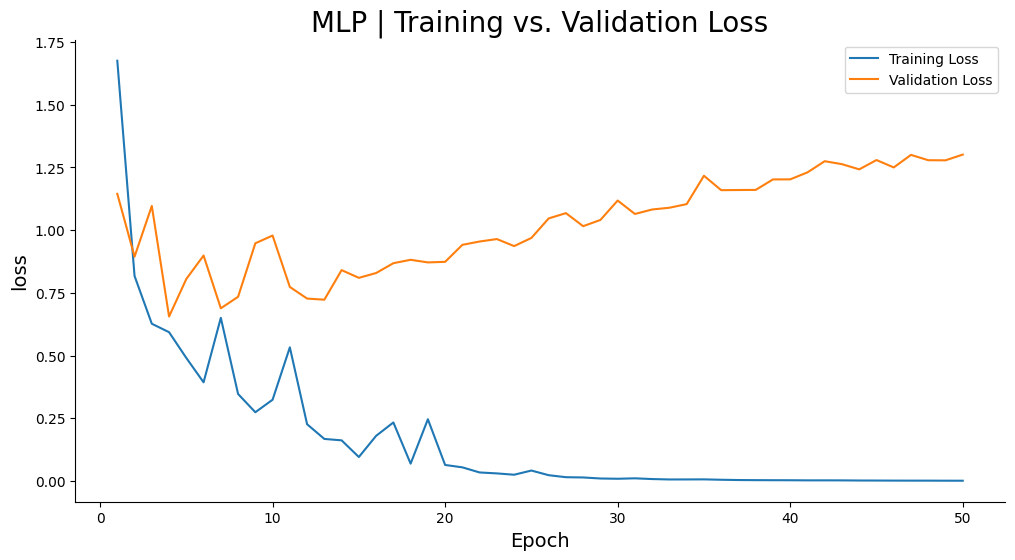

In [ ]:
plt.plot(np.arange(1, 51), history_1.history['loss'], label='Training Loss')
plt.plot(np.arange(1, 51), history_1.history['val_loss'], label='Validation Loss')
plt.title('MLP | Training vs. Validation Loss', size=20)
plt.xlabel('Epoch', size=14)
plt.ylabel('loss', size=14)
plt.legend();

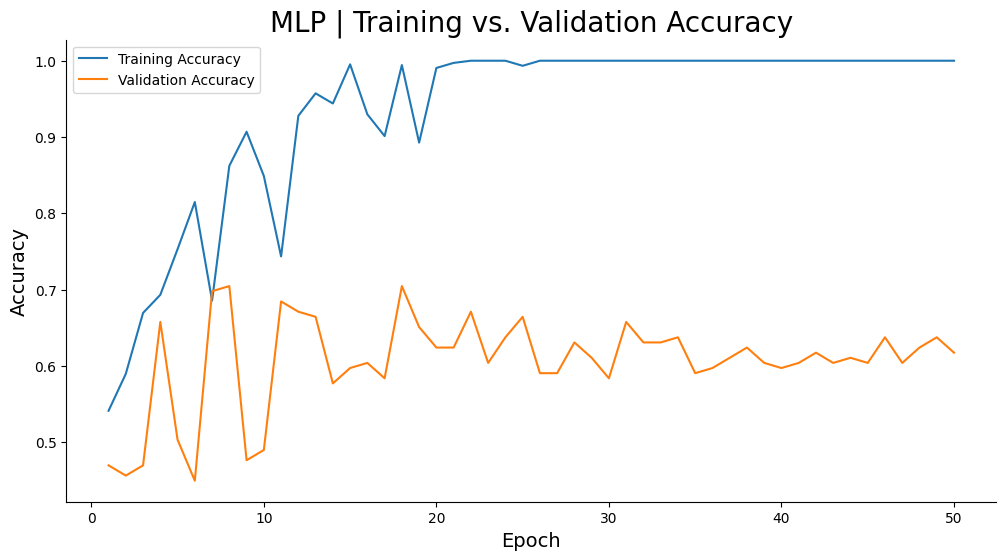

In [ ]:
plt.plot(np.arange(1, 51), history_1.history['accuracy'], label='Training Accuracy')
plt.plot(np.arange(1, 51), history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('MLP | Training vs. Validation Accuracy', size=20)
plt.xlabel('Epoch', size=14)
plt.ylabel('Accuracy', size=14)
plt.legend();

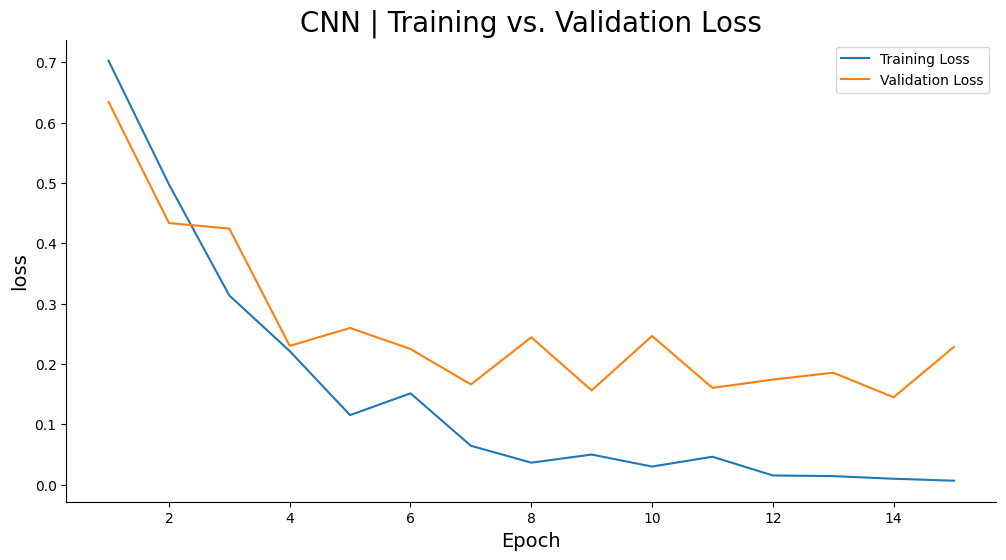

In [ ]:
plt.plot(np.arange(1, 16), history_2.history['loss'], label='Training Loss')
plt.plot(np.arange(1, 16), history_2.history['val_loss'], label='Validation Loss')
plt.title('CNN | Training vs. Validation Loss', size=20)
plt.xlabel('Epoch', size=14)
plt.ylabel('loss', size=14)
plt.legend();

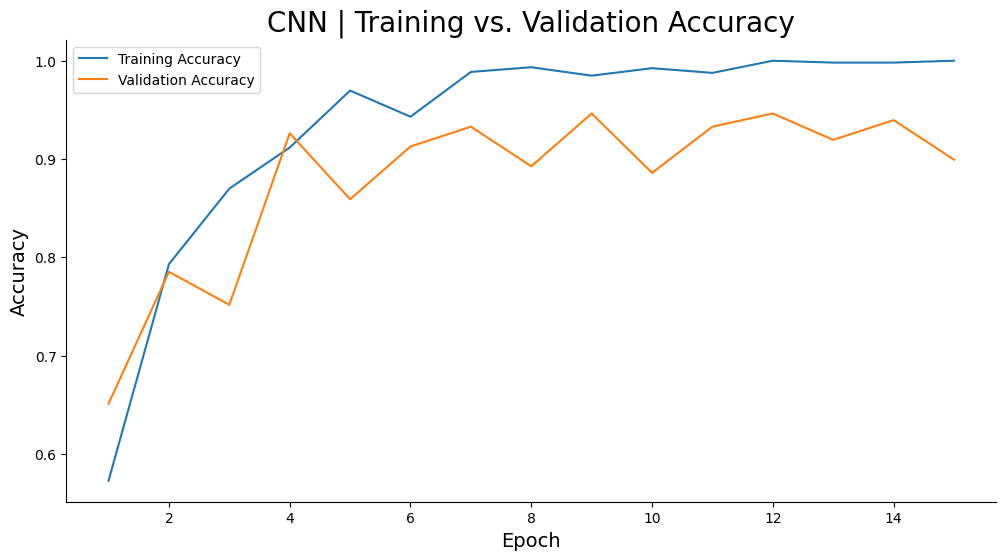

In [ ]:
plt.plot(np.arange(1, 16), history_2.history['accuracy'], label='Training Accuracy')
plt.plot(np.arange(1, 16), history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN | Training vs. Validation Accuracy', size=20)
plt.xlabel('Epoch', size=14)
plt.ylabel('Accuracy', size=14)
plt.legend();